In [1]:
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from glob import glob

In [2]:
list_image = sorted(glob('./data/train/input/img/*.png'))
list_label = sorted(glob('./data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

IMAGE_SHAPE = (80, 120)
data_root = './data/train/input'
label_root = './data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23680 23680
Found 23680 images belonging to 1 classes.
Found 23680 images belonging to 1 classes.


In [3]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

In [4]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.     0.     1.     1.     0.6375 0.375 ]
(80, 120, 3) [0.         0.         1.         1.         0.4        0.33705595]


/home/aiffel0042/anaconda3/envs/coarse/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel0042/anaconda3/envs/coarse/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aiffel0042/anaconda3/envs/coarse/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


### 모델 설계

In [5]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()

(32, 2048)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 25,669,126
Trainable params: 2,104,326
Non-trainable params: 23,564,800
_________________________________________________________________


In [6]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

In [7]:
def lr_step_decay(epoch):
    init_lr = 0.0005 #self.flag.initial_learning_rate
    lr_decay = 0.5 #self.flag.learning_rate_decay_factor
    epoch_per_decay = 2 #self.flag.epoch_per_decay
    lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
    return lrate

In [8]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 20160 32 630 -> 데이터를 batch_size 의 배수로 준비해 주세요.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=20,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23680 32 740
Epoch 1/20


/home/aiffel0042/anaconda3/envs/coarse/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel0042/anaconda3/envs/coarse/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


740/740 [==============================] - 95s 128ms/step - loss: 0.0208 - mae: 0.0673 - lr: 5.0000e-04
Epoch 2/20
740/740 [==============================] - 99s 134ms/step - loss: 0.0126 - mae: 0.0519 - lr: 2.5000e-04
Epoch 3/20
740/740 [==============================] - 98s 132ms/step - loss: 0.0125 - mae: 0.0515 - lr: 2.5000e-04
Epoch 4/20
740/740 [==============================] - 98s 132ms/step - loss: 0.0124 - mae: 0.0511 - lr: 1.2500e-04
Epoch 5/20
740/740 [==============================] - 97s 132ms/step - loss: 0.0124 - mae: 0.0510 - lr: 1.2500e-04
Epoch 6/20
740/740 [==============================] - 96s 129ms/step - loss: 0.0124 - mae: 0.0509 - lr: 6.2500e-05
Epoch 7/20
740/740 [==============================] - 96s 129ms/step - loss: 0.0124 - mae: 0.0508 - lr: 6.2500e-05
Epoch 8/20
740/740 [==============================] - 96s 129ms/step - loss: 0.0123 - mae: 0.0507 - lr: 3.1250e-05
Epoch 9/20
740/740 [==============================] - 96s 129ms/step - loss: 0.0123 - mae: 

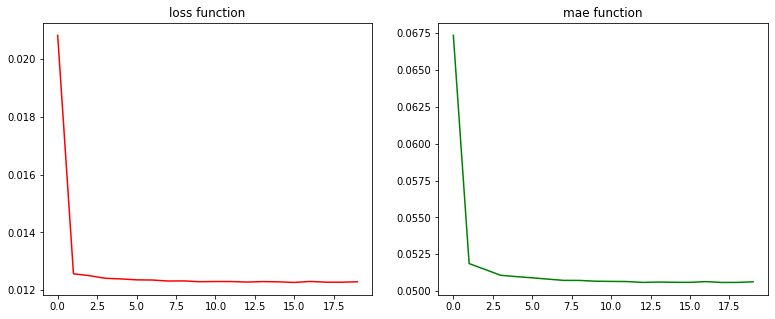

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].plot(history.history['loss'], 'r')
axs[0].set_title('loss function')

axs[1].plot(history.history['mae'], 'g')
axs[1].set_title('mae function')
plt.show()

### 모델 평가하기

In [12]:
IMAGE_SHAPE = (80, 120)
val_data_root = './data/val/input'
val_label_root = './data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2638 images belonging to 1 classes.
Found 2638 images belonging to 1 classes.


In [13]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

/home/aiffel0042/anaconda3/envs/coarse/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel0042/anaconda3/envs/coarse/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


0.012264616787433624 0.05062057450413704


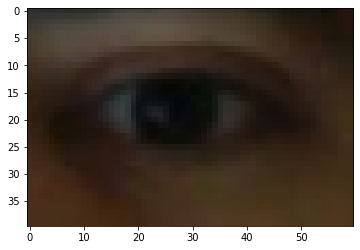

In [361]:
# img test
# img = cv2.imread('./data/val/input/img/eye_000010_l.png')
img = cv2.imread('./data/eye.png')

img = cv2.resize(img, (60, 40))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [362]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[9.96279297e-04 1.02374598e-03]
  [1.19998566e+02 7.99986954e+01]
  [5.33564796e+01 2.72342205e+01]]]


[0. 0.]
[60. 40.]
[26.5 13.5]


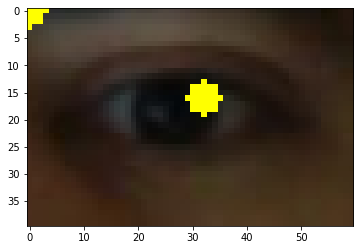

In [363]:
show = img.copy()
for pt in repred[0]:
    show = cv2.circle(show, tuple((pt*0.6).astype(int)), 3, (0,255,255), -1)
    print (pt.round()*0.5)
    
plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

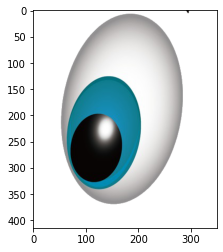

In [377]:
right = cv2.imread('./data/test1.png')
cropped_img = right[170: 1000, 300: 1000]
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.show()

In [378]:
x = int(repred[0][2][0].round()*0.6)
y = int(repred[0][2][1].round()*0.6)
w = 30
h = 30
print ('(x,y) : (%d,%d)'%(x,y))
print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (31,16)
(w,h) : (30,30)


In [379]:
img_sticker = cv2.resize(cropped_img, (w,h))
print (img_sticker.shape)

(30, 30, 3)


In [380]:
refined_x = x - w // 2  # left
refined_y = y - h // 2      # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (16,1)


In [381]:
img_sticker = img_sticker[refined_y:]
print (img_sticker.shape)

(29, 30, 3)


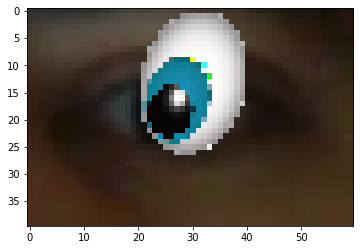

In [382]:
sticker_area = show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Report

눈동자의 중심은 잘 찾고 있지만, 눈의 양쪽은 잘 못찾는 문제가 있습니다.  
데이터를 더 추가하거나 annotation 도구를 통해서 좋은 데이터로 학습을 한다면 더 좋은 결과가 나올 것 같습니다.